Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
original_test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
original_test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, original_test.shape

((59400, 41), (14358, 40))

In [5]:
#val and train split
original_train, original_val = train_test_split(train, train_size=.8, test_size=.2,
                              stratify=train['status_group'], random_state=42)
original_train.shape, original_val.shape, original_test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
def better_wrangle(x):
    x = x.copy()

    x['latitude'] = x['latitude'].replace(-2e-08, 0)

    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        x[col] = x[col].replace(0, np.nan)

    x = x.drop(columns='quantity_group')
    #daterecorded is listed as categorical so putting into datetime format
    x['date_recorded'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    x['recorded_year'] = x['date_recorded'].apply(lambda x: x.year)
    x['recorded_month'] = x['date_recorded'].apply(lambda x: x.month)
    x['recorded_day'] = x['date_recorded'].apply(lambda x: x.day)
    x['recorded_weekday'] = x['date_recorded'].apply(lambda x: x.weekday())

    #changing the year recorded to the mean, if it is 2004 or 2002
    x['recorded_year'] = x['recorded_year'].replace([2002, 2004], np.nan)
    x['recorded_year'] = x['recorded_year'].replace(np.nan, round(x['recorded_year'].mean()))
    
    #getting how old each is
    x['construction_year_for_age'] = x['construction_year'].replace(0, np.nan)
    x['construction_year_for_age'] = x['construction_year_for_age'].replace(np.nan, round(x['construction_year_for_age'].mean()))
    x['age'] = x['recorded_year'] - x['construction_year_for_age']
    

    #making the times categorical so can use for one hot
    x['recorded_year'] = x['recorded_year'].apply(lambda x: str(x))
    x['recorded_month'] = x['recorded_month'].apply(lambda x: str(x))
    x['recorded_day'] = x['recorded_day'].apply(lambda x: str(x))
    x['recorded_weekday'] = x['recorded_weekday'].apply(lambda x: str(x))
    x['age'] = x['age'].apply(lambda x: str(x))
    x['construction_year'] = x['construction_year_for_age'].apply(lambda x: str(x))
    
    #some variables that i think should be categorical are numerical
    x['region_code'] = x['region_code'].apply(lambda x: str(x))
    x['district_code'] = x['district_code'].apply(lambda x: str(x))
    
  
   
    
    #fixing the high cardinality
    cardinality = x.select_dtypes(exclude='number').nunique()
    need_to_fix_cardinality = cardinality[cardinality >=50].index.tolist()
    
    for each in need_to_fix_cardinality:
        top25 = x[each].value_counts()[:25].index.to_list()
        x[each] = x[each].apply(lambda y: 'Other' if y not in top25 else y)

    #lumping all the ones that have at least one private together
    x['num_private'] = x['num_private'].apply(lambda x: x if x == 0 else 1)

    #amount tsh has some outliers so going to replace them with the average
    x['amount_tsh'] = x['amount_tsh'].apply(lambda x: x if x<= 1000 else np.nan)
    #dropping duplicates and unwanted columns
    x = x.drop(columns=['payment_type', 'source_type', 'waterpoint_type_group',
                        'extraction_type_group', 'extraction_type_class',
                        'date_recorded', 'recorded_by', 'construction_year_for_age',
                        'source_class', 'quality_group'])
    return x



train = better_wrangle(original_train)
val = better_wrangle(original_val)
test = better_wrangle(original_test)

In [9]:
target = 'status_group'

train_features = train.drop(columns=[target, 'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

features = numeric_features + categorical_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

y_pred = pipeline.predict(X_val)

Train Accuracy 0.9989478114478114
Validation Accuracy 0.813047138047138


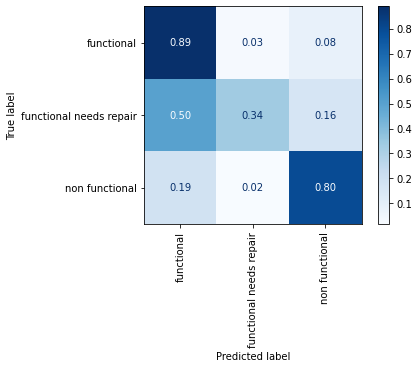

In [10]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(
    pipeline, X_val, y_val,
    xticks_rotation='vertical',
    cmap='Blues',
    values_format='.2f',
    normalize='true'
);